# Heat and Wave Equation Simulations

In [1]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

## Peaceman Rachford ADI Method

In [2]:
def initialf(x,y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)
    
def ADI(d, t, sigma, timesteps, spacesteps, f): # spacesteps and timesteps are the number of iterations through time and space this method will implement, not the size of the time or space step
    k = t/timesteps
    h = d/spacesteps
    
    initialcond = np.zeros((spacesteps + 1, spacesteps + 1)) # initializing a matrix for the initial conditions of the grid
    
    x = np.linspace(0, d, spacesteps + 1) # x values in the [0,1] grid
    y = np.linspace(0, d, spacesteps + 1) # y values in the [0,1] grid

    for i in range (1, spacesteps):
        for j in range(1, spacesteps): # leaving out the 0 and spacesteps + 1 spots because the boundary condition is 0
            initialcond[i,j] = f(x[i], y[j]) # filling in the initial conditions of the grid
            
    solution = np.zeros((timesteps + 1, spacesteps + 1, spacesteps + 1)) # initializing the t,x,y solution matrix
    
    for i in range (0, spacesteps + 1):
        for j in range (0, spacesteps + 1):
            solution[0,i,j] = initialcond[i][j] # adding the initial grid conditions into the solution matrix for t = 0       
    
    A = np.zeros((spacesteps - 1, spacesteps - 1)) # creating the A matrix
    
    UstarMat = np.zeros((spacesteps + 1, spacesteps + 1)) # initializing the matrix that will hold the half time-step updates
    Unplus1Mat = np.zeros((spacesteps + 1,spacesteps + 1)) # initializing the matric that will hold the Un+1 updates
    
    alpha = sigma*(k/(2*h**2))
    
    for i in range (0, spacesteps - 1):
        A[i][i] = 1 + 2*alpha # filling in the diagonal
        
        if i == spacesteps - 2:
            break
            
        A[i][i+1] = -alpha  # filling in the above diagonal
        A[i+1][i] = -alpha # filling in the below diagonal
    #print(A)
    
    for i in range (1, timesteps + 1): # iterating though all the time values 
        
        for j in range (1, spacesteps):
            Ustar = [] # creating a vector that will hold the Ustar values before plugging them into the matrix
            
            for k in range (2, spacesteps + 1):
                Ustar.append(alpha*initialcond[k-2,j] + (1 - (2 * alpha))*initialcond[k-1,j] + alpha*initialcond[k,j])
            UstarMat[1:spacesteps,j] = np.linalg.solve(A,Ustar) # solving for Ustar
            
        for m in range (1, spacesteps):
            Unplus1 = [] # creating a vector that will hold the Un+1 values before plugging them into the matrix 
            
            for k in range (2, spacesteps + 1):
                Unplus1.append(alpha*UstarMat[m,k-2] + (1 - (2 * alpha))*UstarMat[m,k-1] + alpha*UstarMat[m,k])
            Unplus1Mat[m,1:spacesteps] = np.linalg.solve(A,Unplus1) # solving for Unplus1
            
            #print(Unplus1Mat[m,1:-1])    
            
            solution[i,m] = Unplus1Mat[m] # inputting the Unplus1 values into the solution matrix
            initialcond = solution[i,:,:] # updating the initial conditions
            
    return solution 

## Example 1: 2D Heat Diffusion

In this problem, I will implement the ADI method for the initial boundary value problem with the following conditions: 

$x \in [0,1]$

$y \in [0,1]$

$t \in [0, 3]$

$k = .03$

$h = .01$

$D = 1$

$u(0,x,y) = sin(\pi x) sin(\pi y)$

And Dirichlet Boundary conditions. 

The three plots below illustrate the first three time steps of this solutions: $t = 0.0, 0.03, 0.06$.

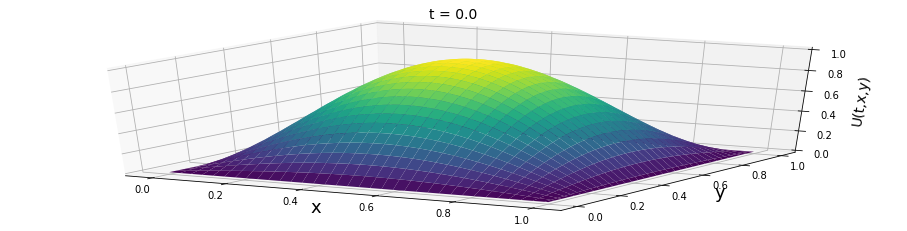

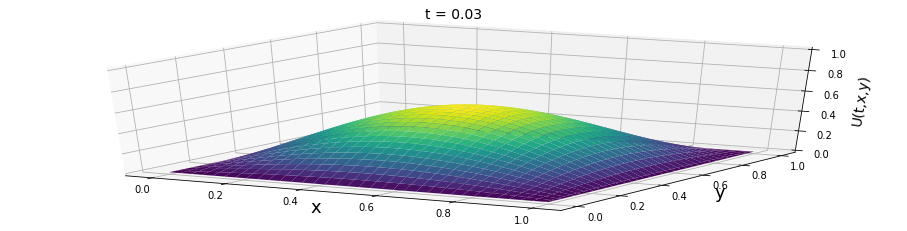

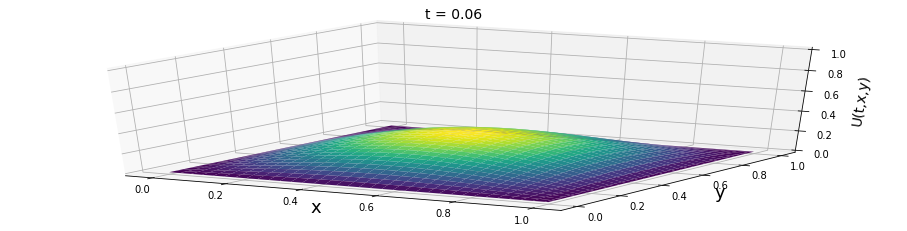

In [4]:
plots = ADI(1, 3, 1, 100, 100, initialf)

xvals = np.linspace(0, 1, 101) 
yvals = np.linspace(0, 1, 101)

x,y = np.meshgrid(xvals, yvals)

for i in range(0,3): 
    fig = plt.figure(figsize = plt.figaspect(0.25)) 
    ax = fig.add_subplot(projection = '3d')
    
    ax.plot_surface(x, y, plots[i,:,:], cmap = "viridis")
    ax.auto_scale_xyz([0, 1], [0, 1], [0, 1])
    ax.set_xlabel("x", fontsize = 18)
    ax.set_ylabel("y", fontsize = 18)
    ax.set_zlabel("U(t,x,y)", fontsize = 14)
    ax.set_title("t = " + str(3* i/100), fontsize = 14)
    
    plt.show()

In these graphs, it can be seen that for these conditions, the head diffuses almost completely in the first few time steps. The colors do not represent the amount of heat, but are instead used to easily see how the heat is diffusing. 

## Example 2: 1D Wave Equation Over Time

In this problem, I will use the Upwind scheme with left boundary condition $u(-1) = 0$, and the following conditions:

$x \in [-1,3]$

$t \in [0, 0.64]$

$k = 0.016$

$h = 0.02$

And two separate intial conditions:

$u(x,0) = e^{-5x^2}$

and $u(x,0) =  \begin{cases} 
      1 - |x| & |x| < 1 \\
      0 & otherwise
   \end{cases}
$ 

Upwind Scheme: $u_j^{n+1} = u_{j}^n - \frac{k}{h}(u_{j}^{n}-u_{j-1}^n)$

In [36]:
def upwind(a, b, T, timesteps, spacesteps, f):
    k = T/timesteps
    h = (b - a)/spacesteps
    
    x = np.arange(a + h, b + h, h)
    
    A = np.zeros((spacesteps, spacesteps))
    
    for i in range(0, spacesteps):
        A[i][i] = 1 - k/h # filling in the diagonal
        
        if i == spacesteps - 1:
            break
            
        A[i][i - 1] = k/h  # filling in the lower diagonal
    
    for i in range (0, spacesteps):
        x[i] = f(x[i])
    
    solution = np.zeros((timesteps + 1, spacesteps ))
    
    for i in range (0 , timesteps + 1):
        if i == 0:
            solution[i,:] = x
        else:
            
            Unplus1 = A.dot(x)
            x = Unplus1
            solution[i,:] = Unplus1
    #print(solution.shape)
    return (np.hstack((np.zeros([41,1]), solution)))

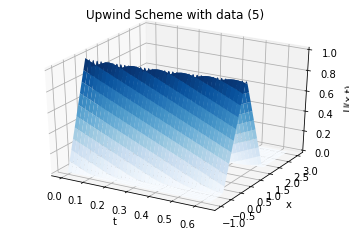

In [37]:
x = np.arange(-1, 3 + 0.02, 0.02)
t = np.arange(0, .64 + 0.016, 0.016)

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
x, t = np.meshgrid(x, t)
u = upwind(-1, 3, .64, 40, 200, f1)
ax.plot_surface(t, x, u, cmap = "Blues")
#ax.view_init(elev = 30, azim = -0)
ax.set_ylabel("x")
ax.set_xlabel("t")
ax.set_zlabel("U(x,t)")
ax.set_title("Upwind Scheme with data (5)")
plt.show()

In the above graph, it can be seen that this method, with the left boundary condition, is stable, and the way the wave move between $t = 0.0$ and $t = 0.64$ can be seen. Below, is another graph of the same problem that shows a different angle of this wave over time.

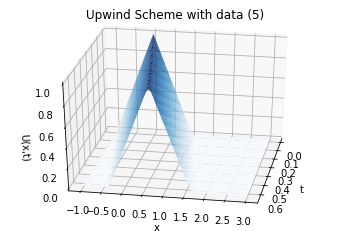

In [38]:
x = np.arange(-1, 3 + 0.02, 0.02)
t = np.arange(0, .64 + 0.016, 0.016)

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
x, t = np.meshgrid(x, t)
u = upwind(-1, 3, .64, 40, 200, f1)
ax.plot_surface(t, x, u, cmap = "Blues")
ax.view_init(elev = 30, azim = 10)
ax.set_ylabel("x")
ax.set_xlabel("t")
ax.set_zlabel("U(x,t)")
ax.set_title("Upwind Scheme with data (5)")
plt.show()

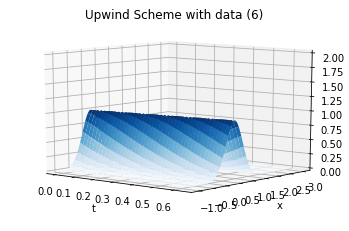

In [39]:
x = np.arange(-1, 3 + 0.02, 0.02)
t = np.arange(0, .64 + 0.016, 0.016)

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
x, t = np.meshgrid(x, t)
u = upwind(-1, 3, .64, 40, 200, f2)
ax.plot_surface(t, x, u, cmap = "Blues")
ax.auto_scale_xyz([0,.64], [-1,3], [0,2])
ax.view_init(elev = 10, azim = -50)
ax.set_ylabel("x")
ax.set_xlabel("t")
ax.set_zlabel("U(x,t)")
ax.set_title("Upwind Scheme with data (6)")
plt.show()

In this graph, you can also see the stable nature of the Upwind scheme, and see how the wave with the second initial condition changes over time. Below is another angle of the same solution.

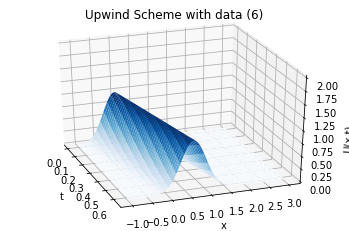

In [40]:
x = np.arange(-1, 3 + 0.02, 0.02)
t = np.arange(0, .64 + 0.016, 0.016)

fig = plt.figure()
ax = fig.add_subplot(projection = '3d')
x, t = np.meshgrid(x, t)
u = upwind(-1, 3, .64, 40, 200, f2)
ax.plot_surface(t, x, u, cmap = "Blues")
ax.auto_scale_xyz([0,.64], [-1,3], [0,2])
ax.view_init(elev = 30, azim = -20)
ax.set_ylabel("x")
ax.set_xlabel("t")
ax.set_zlabel("U(x,t)")
ax.set_title("Upwind Scheme with data (6)")
plt.show()